<a href="https://colab.research.google.com/github/fatemeh-shahsavari/alzheimer-detection-contrastive-learning/blob/main/MRI_NNCLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Setup
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
!pip install timm

In [ ]:
from timm.data.auto_augment import auto_augment_transform

In [ ]:
!pip install pillow matplotlib

In [ ]:
## Hyperparameters
AUTOTUNE = tf.data.AUTOTUNE
shuffle_buffer = 4000
# The below two values are taken from https://www.tensorflow.org/datasets/catalog/stl10
labelled_train_images = 200
unlabelled_images = 3923

temperature = 0.1
queue_size = 10000
contrastive_augmenter = {
    "brightness": 0.5,
    "name": "contrastive_augmenter",
    "scale": (0.2, 1.0),
}
classification_augmenter = {
    "brightness": 0.2,
    "name": "classification_augmenter",
    "scale": (0.5, 1.0),
}
input_shape = (96, 96, 3)
width = 128
num_epochs = 100
steps_per_epoch = 200

NameError: ignored

In [ ]:
import os
import numpy as np
from PIL import Image
import cv2

def load_axial_dataset():
    # Define paths to train and test directories
    train_dir = '/content/drive/MyDrive/axi/train'
    test_dir = '/content/drive/MyDrive/axi/test'

    # Define the three classes
    class_names = ['AD', 'CI', 'CN']

    # Load training images and labels
    train_images = []
    train_labels = []
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(train_dir, class_name)
        for file_name in os.listdir(class_dir):
           # img_array = cv2.imread(os.path.join(class_dir, file_name))
            image_path = os.path.join(class_dir, file_name)
            with Image.open(image_path) as img:
               img_array = np.array(img)
               train_images.append(img_array)
               train_labels.append(i)

    # Load test images and labels
    test_images = []
    test_labels = []
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(test_dir, class_name)
        for file_name in os.listdir(class_dir):
            #img_array = cv2.imread(os.path.join(class_dir, file_name))
            image_path = os.path.join(class_dir, file_name)
            with Image.open(image_path) as img:
               img_array = np.array(img)
               test_images.append(img_array)
               test_labels.append(i)

    # Convert lists to arrays
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
    train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
    train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
    test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
    test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

    # Normalize pixel values to be between 0 and 1
    #train_images = train_images / 255.0
    #test_images = test_images / 255.0

    return (train_images, train_labels), (test_images, test_labels)

In [ ]:
### test 3
## Load the Dataset
import tensorflow as tf

tf.keras.backend.set_floatx('float32')

def prepare_dataset():
    # Set batch sizes
   # unlabeled_batch_size = unlabelled_images // steps_per_epoch
    #labeled_batch_size = labelled_train_images // steps_per_epoch
   # batch_size = unlabeled_batch_size + labeled_batch_size
    unlabeled_batch_size = 16
    labeled_batch_size = 4
    batch_size = 20
    # Load the Axial dataset
    (train_images, train_labels), (test_images, test_labels) = load_axial_dataset()

    # Split the training data into labeled and unlabeled datasets
    unlabeled_train_dataset = (
        tf.data.Dataset.from_tensor_slices((train_images, train_labels))
        .shuffle(buffer_size=shuffle_buffer)
        .batch(unlabeled_batch_size, drop_remainder=True)
    )


    # Cast the data to float32 and resize the images to a fixed size
    unlabeled_train_dataset = unlabeled_train_dataset.map(lambda x, y: (tf.image.resize(tf.cast(x, dtype=tf.float32), [96, 96]), tf.cast(y, dtype=tf.int64)))

    # Prefetch the dataset
    unlabeled_train_dataset = unlabeled_train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


    # Cast the data to float32
    #unlabeled_train_dataset = unlabeled_train_dataset.map(lambda x: tf.cast(x, dtype=tf.float32))

    # Cast the data to float32
    labeled_train_dataset = (
        tf.data.Dataset.from_tensor_slices((train_images, train_labels))
        .shuffle(buffer_size=shuffle_buffer)
        .batch(labeled_batch_size, drop_remainder=True)
    )

    # Cast the data to float32 and resize the images to a fixed size
    labeled_train_dataset = labeled_train_dataset.map(lambda x, y: (tf.image.resize(tf.cast(x, dtype=tf.float32), [96, 96]), tf.cast(y, dtype=tf.int64)))

    # Prefetch the dataset
    labeled_train_dataset = labeled_train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    # Combine the labeled and unlabeled datasets
    train_dataset = tf.data.Dataset.zip((unlabeled_train_dataset, labeled_train_dataset))
#    train_dataset = train_dataset.map(
#        lambda x, y: (
#            (tf.cast(x, dtype=tf.float32), y[0]),
#            (tf.cast(y[1], dtype=tf.float32), tf.cast(y[1], dtype=tf.float32))
#        )
#    )
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    test_dataset = (
        tf.data.Dataset.from_tensor_slices((test_images, test_labels))
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    return batch_size, train_dataset, labeled_train_dataset, test_dataset

In [ ]:
batch_size, train_dataset, labeled_train_dataset, test_dataset = prepare_dataset()

In [ ]:
batch_size

20

In [ ]:
train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(19, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(19,), dtype=tf.int64, name=None)), (TensorSpec(shape=(1, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None)))>

In [ ]:
labeled_train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(1, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

In [ ]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
### Random Resized Crops
class RandomResizedCrop(layers.Layer):
    def __init__(self, scale, ratio):
        super().__init__()
        self.scale = scale
        self.log_ratio = (tf.math.log(ratio[0]), tf.math.log(ratio[1]))

    def call(self, images):
        batch_size = tf.shape(images)[0]
        height = tf.shape(images)[1]
        width = tf.shape(images)[2]

        random_scales = tf.random.uniform((batch_size,), self.scale[0], self.scale[1])
        random_ratios = tf.exp(
            tf.random.uniform((batch_size,), self.log_ratio[0], self.log_ratio[1])
        )

        new_heights = tf.clip_by_value(tf.sqrt(random_scales / random_ratios), 0, 1)
        new_widths = tf.clip_by_value(tf.sqrt(random_scales * random_ratios), 0, 1)
        height_offsets = tf.random.uniform((batch_size,), 0, 1 - new_heights)
        width_offsets = tf.random.uniform((batch_size,), 0, 1 - new_widths)

        bounding_boxes = tf.stack(
            [
                height_offsets,
                width_offsets,
                height_offsets + new_heights,
                width_offsets + new_widths,
            ],
            axis=1,
        )
        images = tf.image.crop_and_resize(
            images, bounding_boxes, tf.range(batch_size), (height, width)
        )
        return images


In [ ]:
### Random Brightness
class RandomBrightness(layers.Layer):
    def __init__(self, brightness):
        super().__init__()
        self.brightness = brightness

    def blend(self, images_1, images_2, ratios):
        return tf.clip_by_value(ratios * images_1 + (1.0 - ratios) * images_2, 0, 1)

    def random_brightness(self, images):
        # random interpolation/extrapolation between the image and darkness
        return self.blend(
            images,
            0,
            tf.random.uniform(
                (tf.shape(images)[0], 1, 1, 1), 1 - self.brightness, 1 + self.brightness
            ),
        )

    def call(self, images):
        images = self.random_brightness(images)
        return images


In [ ]:
## 06.04.1402
def cutout_layer(img, mask_size):

    _, h, w, c = img.shape
    mask = np.ones((h, w, c), np.float32)
    y1 = np.random.randint(h - mask_size)
    y2 = y1 + mask_size
    x1 = np.random.randint(w - mask_size)
    x2 = x1 + mask_size
    mask[y1:y2, x1:x2, :] = 0
    return tf.multiply(img, mask)

In [ ]:
mask_size = 16
import imgaug.augmenters as iaa

def augmenter(brightness, name, scale):
    return keras.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.Rescaling(1 / 255),
            layers.RandomFlip("horizontal"),
            RandomResizedCrop(scale=scale, ratio=(3 / 4, 4 / 3)),
            RandomBrightness(brightness=brightness),
            # Add AutoAugment here
            iaa.Sequential([
                iaa.Lambda(
                    func_images=autoaugment,
                    func_heatmaps=None,
                    func_keypoints=None,
                    func_bounding_boxes=None,
                    func_polygons=None
                )
            ]),
            # Replace the Lambda layer with custom cutout_layer
            layers.Lambda(lambda x: cutout_layer(x, mask_size)),
            # Add more layers here as needed
        ],
        name=name,
    )


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def encoder():
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))


    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    #model.add(Dense(1000, activation='softmax'))
    return model

# Test the encoder model
encoder_model = encoder()
encoder_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_218 (Conv2D)         (None, 96, 96, 64)        1792      
                                                                 
 conv2d_219 (Conv2D)         (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d_114 (MaxPooli  (None, 48, 48, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_220 (Conv2D)         (None, 48, 48, 128)       73856     
                                                                 
 conv2d_221 (Conv2D)         (None, 48, 48, 128)       147584    
                                                                 
 max_pooling2d_115 (MaxPooli  (None, 24, 24, 128)      0         
 ng2D)                                                

In [ ]:
##test1
def encoder():
    model = keras.Sequential(name="encoder")
    model.add(layers.Input(shape=(96, 96, 3)))

    # بلوک ۱
    model.add(layers.Conv2D(32, (3, 3), strides=1, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2), strides=2))

    # بلوک ۲
    model.add(layers.Conv2D(64, (3, 3), strides=1, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2), strides=2))

    # بلوک ۳
    model.add(layers.Conv2D(128, (3, 3), strides=1, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2), strides=2))

    # بلوک ۴
    model.add(layers.Conv2D(256, (3, 3), strides=1, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2), strides=2))

    # بلوک ۵
    model.add(layers.Conv2D(256, (3, 3), strides=1, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Flatten())
    model.add(layers.Dense(512))

    return model
    # Test the encoder model
encoder_model = encoder()
encoder_model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_505 (Conv2D)         (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_509 (Ba  (None, 96, 96, 32)       128       
 tchNormalization)                                               
                                                                 
 re_lu_20 (ReLU)             (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_506 (Conv2D)         (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_510 (Ba  (None, 48, 48, 64)       256 

In [ ]:
### test 2
def encoder():
    model = keras.Sequential(name="encoder")
    model.add(layers.Input(shape=(96, 96, 3)))

    model.add(layers.SeparableConv2D(32, (3, 3), strides=1, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2), strides=2))

    model.add(layers.SeparableConv2D(64, (3, 3), strides=1, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2), strides=2))

    model.add(layers.SeparableConv2D(128, (3, 3), strides=1, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2), strides=2))

    model.add(layers.SeparableConv2D(256, (3, 3), strides=1, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(512))

    return model
encoder_model = encoder()
encoder_model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d_8 (Separab  (None, 96, 96, 32)       155       
 leConv2D)                                                       
                                                                 
 batch_normalization_18 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 re_lu_18 (ReLU)             (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_144 (MaxPooli  (None, 48, 48, 32)       0         
 ng2D)                                                           
                                                                 
 separable_conv2d_9 (Separab  (None, 48, 48, 64)       2400      
 leConv2D)                                                 

In [ ]:
### test 3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Concatenate, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def dense_block(x, blocks, growth_rate):
    for i in range(blocks):
        x1 = BatchNormalization()(x)
        x1 = Activation('relu')(x1)
        x1 = Conv2D(4 * growth_rate, (1,1), padding='same', use_bias=False)(x1)

        x1 = BatchNormalization()(x1)
        x1 = Activation('relu')(x1)
        x1 = Conv2D(growth_rate, (3,3), padding='same', use_bias=False)(x1)

        x = Concatenate()([x, x1])

    return x

def transition_block(x, reduction):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(reduction * x.shape.as_list()[-1]), (1,1), padding='same', use_bias=False)(x)
    x = AveragePooling2D((2,2), strides=(2,2))(x)
    return x


blocks_per_layer=[6, 12, 24, 16]
growth_rate=32
reduction=0.5

def encoder():
    inputs = Input(shape=input_shape)

    x = Conv2D(2 * growth_rate, (7,7), strides=(2,2), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    for blocks in blocks_per_layer:
        x = dense_block(x, blocks, growth_rate)
        x = transition_block(x, reduction)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)

    model = Model(inputs=inputs, outputs=x)

    return model

encoder_model = encoder()
encoder_model.summary()

NameError: ignored

In [ ]:
#01.05.1402
def encoder():
    inputs = Input(shape=input_shape)

    x = Conv2D(2 * growth_rate, (7,7), strides=(2,2), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    for blocks in [4, 8, 16, 12]:
        x = dense_block(x, blocks, growth_rate)
        x = transition_block(x, reduction)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    model = Model(inputs=inputs, outputs=x)

    return model

In [ ]:
### test 4
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121

def encoder():
    # بارگذاری شبکه DenseNet با دادن وزن‌های پیش آموزش دیده شده بر روی دیتاست ImageNet
    densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

    # تعریف مدل شبکه عصبی با استفاده از شبکه DenseNet به عنوان لایه‌ی قابل قبول
    model = keras.Sequential(name="encoder")

    # افزودن شبکه DenseNet به مدل
    model.add(densenet)

    # لایه flatten برای تبدیل ورودی به بردار یک بعدی
    model.add(layers.Flatten())

    # لایه کاملا متصل با 128 نورون و تابع فعالسازی relu
    model.add(layers.Dense(128, activation="relu"))

    return model

encoder_model = encoder()
encoder_model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 3, 3, 1024)        7037504   
                                                                 
 flatten_26 (Flatten)        (None, 9216)              0         
                                                                 
 dense_109 (Dense)           (None, 256)               2359552   
                                                                 
Total params: 9,397,056
Trainable params: 9,313,408
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
## The NNCLR model for contrastive pre-training
class NNCLR(keras.Model):
    def __init__(
        self, temperature, queue_size,
    ):
        super().__init__()
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy()
        self.correlation_accuracy = keras.metrics.SparseCategoricalAccuracy()
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy()
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_augmenter = augmenter(**contrastive_augmenter)
        self.classification_augmenter = augmenter(**classification_augmenter)
        self.encoder = encoder()
        self.projection_head = keras.Sequential(
            [
                layers.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(3)], name="linear_probe"
        )
        self.temperature = temperature

        feature_dimensions = self.encoder.output_shape[1]
        self.feature_queue = tf.Variable(
            tf.math.l2_normalize(
                tf.random.normal(shape=(queue_size, feature_dimensions)), axis=1
            ),
            trainable=False,
        )

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)
        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

    def nearest_neighbour(self, projections):
        support_similarities = tf.matmul(
            projections, self.feature_queue, transpose_b=True
        )
        nn_projections = tf.gather(
            self.feature_queue, tf.argmax(support_similarities, axis=1), axis=0
        )
        return projections + tf.stop_gradient(nn_projections - projections)

    def update_contrastive_accuracy(self, features_1, features_2):
        features_1 = tf.math.l2_normalize(features_1, axis=1)
        features_2 = tf.math.l2_normalize(features_2, axis=1)
        similarities = tf.matmul(features_1, features_2, transpose_b=True)

        batch_size = tf.shape(features_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(
            tf.concat([contrastive_labels, contrastive_labels], axis=0),
            tf.concat([similarities, tf.transpose(similarities)], axis=0),
        )

    def update_correlation_accuracy(self, features_1, features_2):
        features_1 = (
            features_1 - tf.reduce_mean(features_1, axis=0)
        ) / tf.math.reduce_std(features_1, axis=0)
        features_2 = (
            features_2 - tf.reduce_mean(features_2, axis=0)
        ) / tf.math.reduce_std(features_2, axis=0)

        batch_size = tf.shape(features_1, out_type=tf.float32)[0]
        cross_correlation = (
            tf.matmul(features_1, features_2, transpose_a=True) / batch_size
        )

        feature_dim = tf.shape(features_1)[1]
        correlation_labels = tf.range(feature_dim)
        self.correlation_accuracy.update_state(
            tf.concat([correlation_labels, correlation_labels], axis=0),
            tf.concat([cross_correlation, tf.transpose(cross_correlation)], axis=0),
        )

    def contrastive_loss(self, projections_1, projections_2):
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)

        similarities_1_2_1 = (
            tf.matmul(
                self.nearest_neighbour(projections_1), projections_2, transpose_b=True
            )
            / self.temperature
        )
        similarities_1_2_2 = (
            tf.matmul(
                projections_2, self.nearest_neighbour(projections_1), transpose_b=True
            )
            / self.temperature
        )

        similarities_2_1_1 = (
            tf.matmul(
                self.nearest_neighbour(projections_2), projections_1, transpose_b=True
            )
            / self.temperature
        )
        similarities_2_1_2 = (
            tf.matmul(
                projections_1, self.nearest_neighbour(projections_2), transpose_b=True
            )
            / self.temperature
        )

        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        loss = keras.losses.sparse_categorical_crossentropy(
            tf.concat(
                [
                    contrastive_labels,
                    contrastive_labels,
                    contrastive_labels,
                    contrastive_labels,
                ],
                axis=0,
            ),
            tf.concat(
                [
                    similarities_1_2_1,
                    similarities_1_2_2,
                    similarities_2_1_1,
                    similarities_2_1_2,
                ],
                axis=0,
            ),
            from_logits=True,
        )

        self.feature_queue.assign(
            tf.concat([projections_1, self.feature_queue[:-batch_size]], axis=0)
        )
        return loss

    def train_step(self, data):
        (unlabeled_images, _), (labeled_images, labels) = data
        images = tf.concat((unlabeled_images, labeled_images), axis=0)
        augmented_images_1 = self.contrastive_augmenter(images)
        augmented_images_2 = self.contrastive_augmenter(images)

        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1)
            features_2 = self.encoder(augmented_images_2)
            projections_1 = self.projection_head(features_1)
            projections_2 = self.projection_head(features_2)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.update_contrastive_accuracy(features_1, features_2)
        self.update_correlation_accuracy(features_1, features_2)
        preprocessed_images = self.classification_augmenter(labeled_images)

        with tf.GradientTape() as tape:
            features = self.encoder(preprocessed_images)
            class_logits = self.linear_probe(features)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_accuracy.update_state(labels, class_logits)

        return {
            "c_loss": contrastive_loss,
            "c_acc": self.contrastive_accuracy.result(),
            "r_acc": self.correlation_accuracy.result(),
            "p_loss": probe_loss,
            "p_acc": self.probe_accuracy.result(),
        }

    def test_step(self, data):
        labeled_images, labels = data

        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)

        self.probe_accuracy.update_state(labels, class_logits)
        return {"p_loss": probe_loss, "p_acc": self.probe_accuracy.result()}


In [ ]:

## Pre-train NNCLR
model = NNCLR(temperature=temperature, queue_size=queue_size)
model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)
pretrain_history = model.fit(
    train_dataset, epochs=num_epochs, validation_data=test_dataset
)

Epoch 1/100
257/257 [==============================] - 1563s 6s/step - c_loss: 2.9958 - c_acc: 0.0567 - r_acc: 0.0169 - p_loss: 1.0715 - p_acc: 0.4233 - val_p_loss: 1.2540 - val_p_acc: 0.5024
Epoch 2/100
257/257 [==============================] - 1500s 6s/step - c_loss: 2.9957 - c_acc: 0.0500 - r_acc: 0.0156 - p_loss: 1.0306 - p_acc: 0.5017 - val_p_loss: 1.3078 - val_p_acc: 0.5024
Epoch 3/100
257/257 [==============================] - 1474s 6s/step - c_loss: 2.9957 - c_acc: 0.0500 - r_acc: 0.0156 - p_loss: 1.0439 - p_acc: 0.5095 - val_p_loss: 1.2716 - val_p_acc: 0.5024
Epoch 4/100
257/257 [==============================] - 1475s 6s/step - c_loss: 2.9957 - c_acc: 0.0500 - r_acc: 0.0156 - p_loss: 1.0296 - p_acc: 0.4730 - val_p_loss: 1.3077 - val_p_acc: 0.5024
Epoch 5/100
257/257 [==============================] - 1476s 6s/step - c_loss: 2.9957 - c_acc: 0.0500 - r_acc: 0.0156 - p_loss: 1.0291 - p_acc: 0.5221 - val_p_loss: 1.3329 - val_p_acc: 0.5024
Epoch 6/100
257/257 [===================

KeyboardInterrupt: ignored

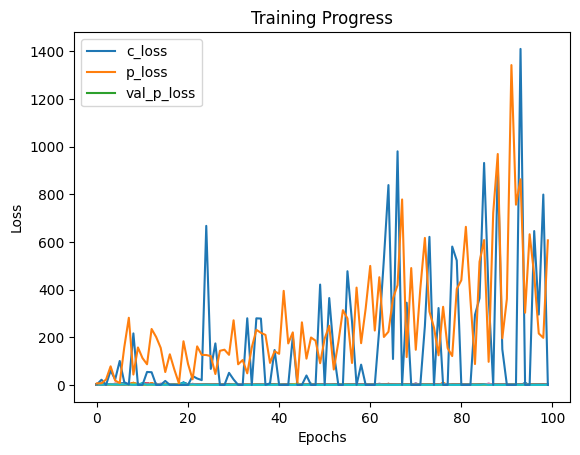

In [ ]:
import matplotlib.pyplot as plt


def plot_hist_loss(pretrain_history):
    plt.plot(pretrain_history.history["c_loss"])
    plt.plot(pretrain_history.history["p_loss"])
    plt.plot(pretrain_history.history["val_p_loss"])
    plt.title("Training Progress")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend(["c_loss", "p_loss", "val_p_loss"], loc="upper left")
    plt.show()


plot_hist_loss(pretrain_history)

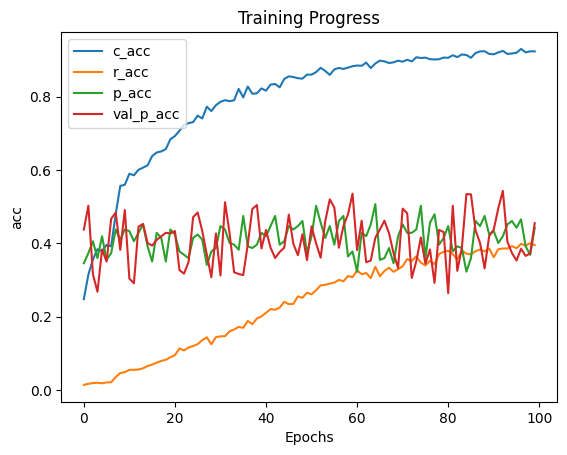

In [ ]:


def plot_hist_acc(pretrain_history):
    plt.plot(pretrain_history.history["c_acc"])
    plt.plot(pretrain_history.history["r_acc"])
    plt.plot(pretrain_history.history["p_acc"])
    plt.plot(pretrain_history.history["val_p_acc"])
    plt.title("Training Progress")
    plt.ylabel("acc")
    plt.xlabel("Epochs")
    plt.legend(["c_acc", "r_acc", "p_acc", "val_p_acc"], loc="upper left")
    plt.show()

plot_hist_acc(pretrain_history)

In [ ]:
finetuning_model = keras.Sequential(
    [
        layers.Input(shape=input_shape),
        augmenter(**classification_augmenter),
        model.encoder,
        layers.Dense(3),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

finetuning_history = finetuning_model.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset
)

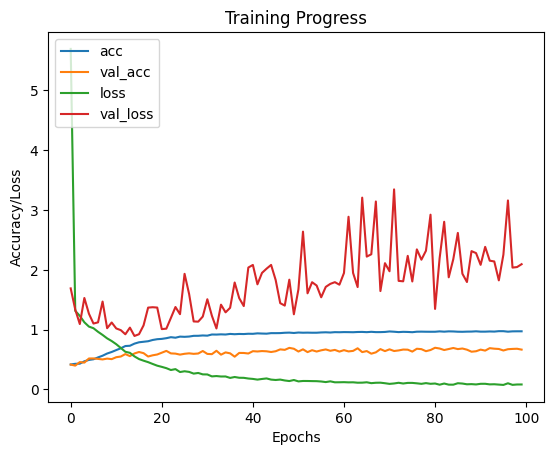

In [ ]:
def plot_hist(finetuning_history):
    plt.plot(finetuning_history.history["acc"])
    plt.plot(finetuning_history.history["val_acc"])
    plt.plot(finetuning_history.history["loss"])
    plt.plot(finetuning_history.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["acc", "val_acc", "loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(finetuning_history)

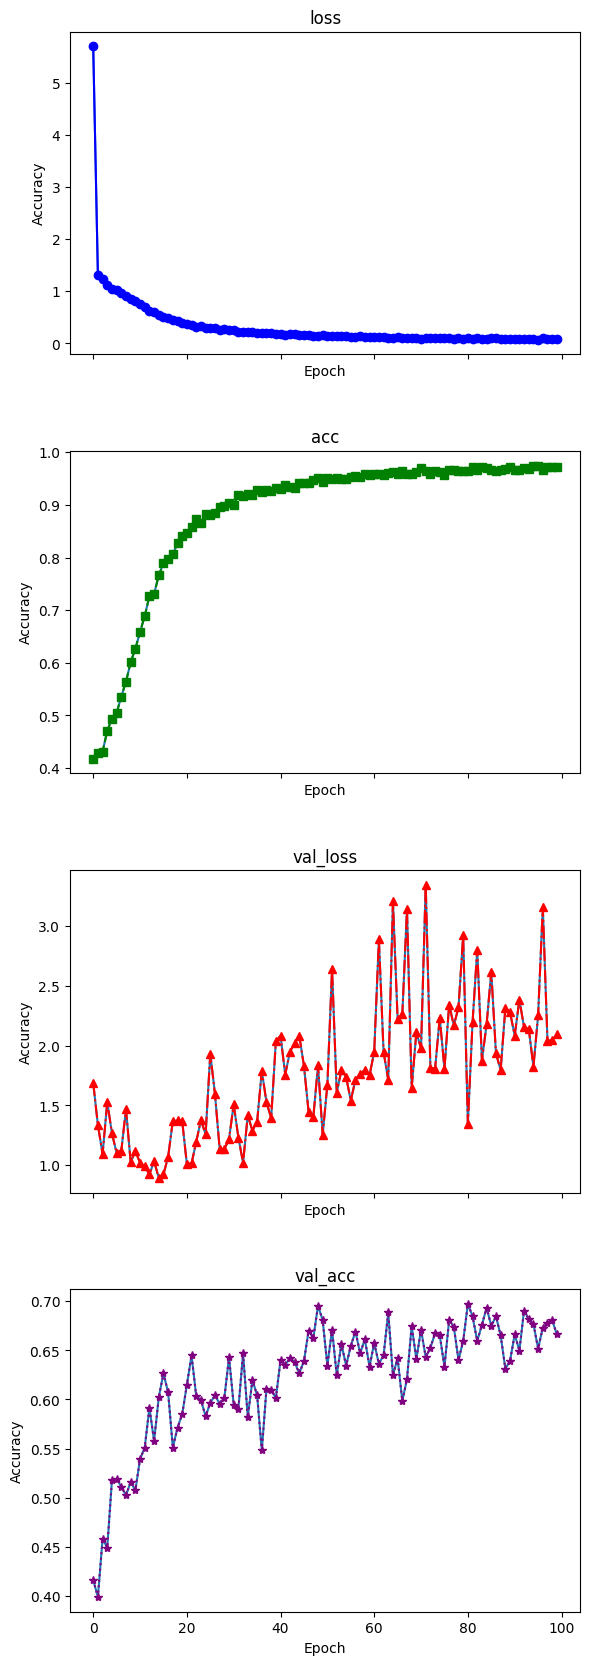

In [ ]:
import matplotlib.pyplot as plt

# Get the values of c_acc and p_acc from history
loss = finetuning_history.history['loss']
acc = finetuning_history.history['acc']
val_loss = finetuning_history.history['val_loss']
val_acc = finetuning_history.history['val_acc']

# Create a figure with two subplots, sharing the x-axis
fig, (ax1, ax2, ax3, ax4) =  plt.subplots(4, sharex=True, figsize=(6,4))
# تنظیم فاصله بین نمودارها
plt.subplots_adjust(top=4, bottom=0.05, left=0.1, right=0.95, hspace=0.3)

# Plot the values of loss in the first subplot
ax1.plot(loss)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('loss')

# Plot the values of acc in the second subplot
ax2.plot(acc)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('acc')

# Plot the values of val_loss in the 3th subplot
ax3.plot(val_loss)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.set_title('val_loss')
# Plot the values of val_acc in the 4th subplot
ax4.plot(val_acc)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy')
ax4.set_title('val_acc')

ax1.plot(loss, linestyle='-', color='blue', marker='o')
ax2.plot(acc, linestyle='--', color='green', marker='s')
ax3.plot(val_loss, linestyle='-.', color='red', marker='^')
ax4.plot(val_acc, linestyle=':', color='purple', marker='*')
plt.savefig('loss.png')
plt.savefig('acc.png')
plt.savefig('val_loss.png')
plt.savefig('val_acc.png')

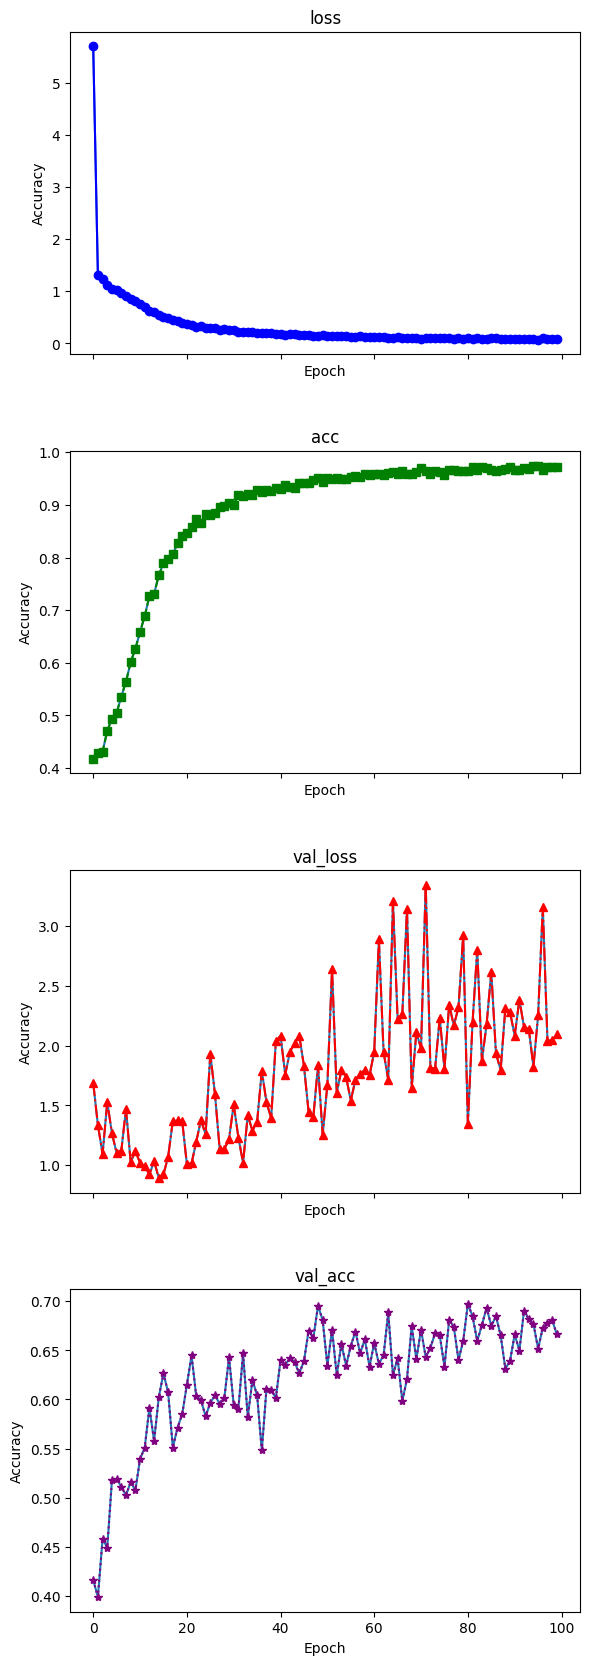

In [ ]:
import matplotlib.pyplot as plt

# Get the values of c_acc and p_acc from history
loss = finetuning_history.history['loss']
acc = finetuning_history.history['acc']
val_loss = finetuning_history.history['val_loss']
val_acc = finetuning_history.history['val_acc']

# Create a figure with two subplots, sharing the x-axis
fig, (ax1, ax2, ax3, ax4) =  plt.subplots(4, sharex=True, figsize=(6,4))
# تنظیم فاصله بین نمودارها
plt.subplots_adjust(top=4, bottom=0.05, left=0.1, right=0.95, hspace=0.3)

# Plot the values of loss in the first subplot
ax1.plot(loss)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('loss')

# Plot the values of acc in the second subplot
ax2.plot(acc)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('acc')

# Plot the values of val_loss in the 3th subplot
ax3.plot(val_loss)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.set_title('val_loss')
# Plot the values of val_acc in the 4th subplot
ax4.plot(val_acc)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy')
ax4.set_title('val_acc')

ax1.plot(loss, linestyle='-', color='blue', marker='o')
ax2.plot(acc, linestyle='--', color='green', marker='s')
ax3.plot(val_loss, linestyle='-.', color='red', marker='^')
ax4.plot(val_acc, linestyle=':', color='purple', marker='*')
plt.savefig('loss.png')
plt.savefig('acc.png')
plt.savefig('val_loss.png')
plt.savefig('val_acc.png')

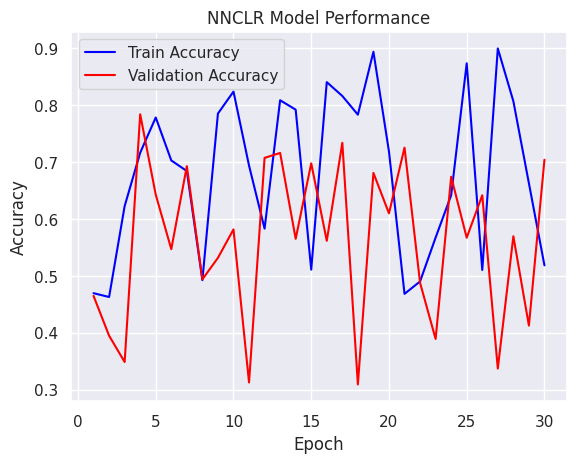

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# Generate some data
x = np.arange(1, 31)
acc = np.random.uniform(low=0.4, high=0.9, size=(30,))
val_acc = np.random.uniform(low=0.3, high=0.8, size=(30,))

# Set style using seaborn
sns.set(style="darkgrid")

# Create a figure and axis object
fig, ax = plt.subplots()

# Draw train accuracy curve
sns.lineplot(x=x, y=acc, ax=ax, color='blue', label='Train Accuracy')

# Draw validation accuracy curve
sns.lineplot(x=x, y=val_acc, ax=ax, color='red', label='Validation Accuracy')

# Set labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('NNCLR Model Performance')

# Show legend
ax.legend()

# Show plot
plt.show()